In [53]:
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import boto3
import sys
import os
import pandas as pd

In [54]:
sys.path.append(os.path.expanduser('~'))
from scripts.utils.write_metadata import (
    make_metadata_files, 
    append_metadata
)

In [55]:
@append_metadata
def crop_condition_moisture(input_nc_file, output_nc_file, variable_name=''):
    '''
    Opens a netcdf file for either soil moisture anamoly or evaporative stress index data and reprojects/clips them to California boundaries
    EPSG: 4269. The final output is a reprojected .nc file.

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
    
    Parameters
    ----------
    input_nc_file: string
        Name of origional .nc file

    output_file_name: string
        Final output as a .nc file

    variable_name: string
        Name of the variable associated with the data:
            Soil moisture: 'ssma'
            Evaporative stress index: 'esi'
    '''

    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  
    directory = '2b_reproject/natural_systems/agricultural_productivity_conservation/usda_nasa'

    data = xr.open_dataset(input_nc_file)

    # establish working range for parameters outlined in the xarray
    lat_min = data['latitude'].min()
    lat_max = data['latitude'].max()
    lon_min = data['longitude'].min()
    lon_max = data['longitude'].max()

    filtered_data = data[variable_name].sel(  
                        latitude=slice(lat_min, lat_max),  
                        longitude=slice(lon_min, lon_max),  
                        )

    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min

    # visualize the .nc for the first date within the data
    filtered_data.isel(time=23).plot.imshow(vmin=-4., vmax=4., cmap='seismic', aspect=lon_range/lat_range, size=5)
    # Add a title
    plt.title('.nc file before reproject & CA subset')
    # Display the plot
    plt.show()
    
    # load the census tracts spatial data for California
    ca_boundaries = gpd.read_file('2021_ca_tract')

    # check the current coordinate system of the census tracts data
    print("Original CRS of Census Tracts Data:")
    print(ca_boundaries.crs)
    
    # reproject soil data to the same coordinate system as census tract
    filtered_data_repoj = filtered_data.rio.set_crs('EPSG:4269')

    # clip the reprojected data to California specific census parameter
    filtered_data_repoj.rio.clip(geometries=ca_boundaries.geometry)

    visualize_ca_evap_stress = filtered_data_repoj.rio.clip(geometries=ca_boundaries.geometry).isel(time=23)
    fig, ax = plt.subplots()
    visualize_ca_evap_stress.plot(ax=ax)

    # plot the shapefile on top of the xarray plot
    ca_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    plt.title('Evaporative stress after reproject & CA subset')
    # Show the plot
    plt.show()

    # save newly projected data as a netcdf file
    filtered_data_repoj.to_netcdf(output_nc_file)
    print(f"Reprojected and Subsetted Evaporative stress data saved as: {variable_name}_ca_reproject.nc")

    # upload to aws bucket
    with open(output_nc_file, 'rb') as data:
            s3_client.upload_fileobj(data, bucket_name, f"{directory}/{output_nc_file}")
            print("Merged and sorted files written to:", output_nc_file)
        
    # Close the NetCDF file
    data.close()

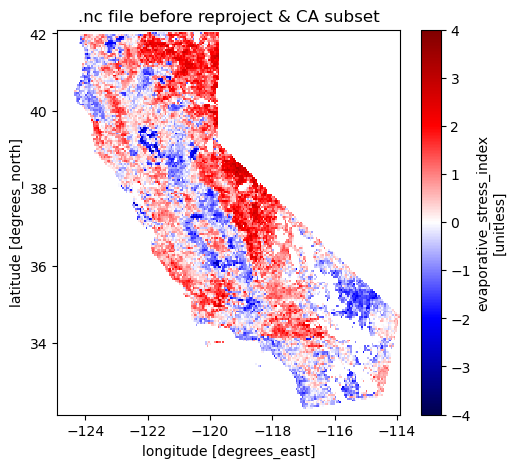

Original CRS of Census Tracts Data:
EPSG:4269


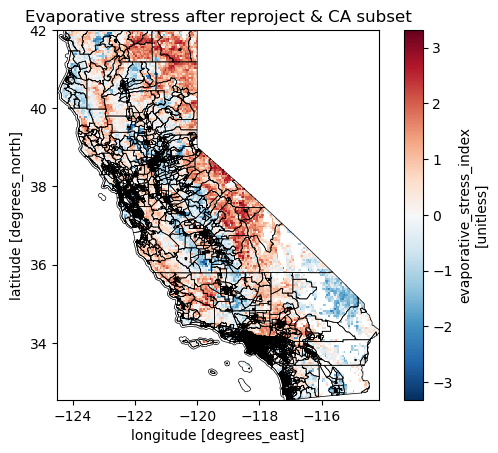

Reprojected and Subsetted Evaporative stress data saved as: esi_ca_reproject.nc
Merged and sorted files written to: evaporative_stress_ca_reproject(1).nc


In [23]:
crop_condition_moisture('evaporative_stress_index_12week_2015-2022.nc', 'evaporative_stress_ca_reproject.nc', 'esi')

In [ ]:
crop_condition_moisture('sfc_soil_moisture_anomaly_2015-2022.nc', 'soil_moisture_anom_ca_reproject.nc', 'ssma')